In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Get all validated flares

In [3]:
df = pd.read_csv("../results/2020_02_flares_vetted.csv")

In [6]:
flares = df[df["real?"]==1]

In [107]:
flares.ID.unique().shape

(151,)

In [142]:
rvtran = pd.read_csv("../results/2021_03_star_planet_systems_with_flares.csv")
transit = rvtran[rvtran.discoverymethod.isnull()].ID

In [143]:
flares = flares.merge(transit, how="inner", on="ID")

In [144]:
flares.ID.unique().shape

(133,)

### Calculate all flare phases

In [145]:
def get_flare_phases(df, mode):
    phases = []
    
    if mode=="Orbit":
        for j, row in df.iterrows():
            try:
                lc = pd.read_csv(f"../results/observedtimes/{row.ID}_{row.qcs}_{row.lc_n}_{row.mission}.csv")
                phases.append(lc.phase[np.argmin(np.abs(lc.time - row.tstart))])
            except Exception as e:
                print(e)
                phases.append(np.nan)
        df["phases"] = phases
                
    elif mode=="Rotation":
        
        df["phases"] = (df.tstart % rotper) / rotper
        
    return df

In [146]:
wphases = get_flare_phases(flares, "Orbit")

[Errno 2] No such file or directory: '../results/observedtimes/TOI-700_27_0_TESS.csv'
[Errno 2] No such file or directory: '../results/observedtimes/TIC 420112587_22_1_TESS.csv'
[Errno 2] No such file or directory: '../results/observedtimes/TIC 420112587_26_1_TESS.csv'


In [44]:
flarephases = np.sort(wphases.phases.dropna().values)

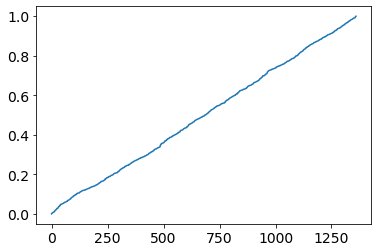

In [79]:
plt.plot(flarephases)

### Get all observed phases

In [46]:
def get_observed_phases(obstimes, mode, flarephases):
    
    # bin array is two elements longer than the number of bins
    # to include 0 and 1
    bins = np.zeros(len(flarephases) +2) 
    
    # add zero and one
    bins[0] = 0 
    bins[-1] = 1 
    
    # and the others are kept as defined by observations
    bins[1:-1] = flarephases
    
    obsphases = pd.DataFrame()

    for i, row in obstimes.iterrows():
        lc = pd.read_csv(f"../results/observedtimes/{row.ID}_{row.qcs}_{row.lc_n}_{row.mission}.csv")
        
        if mode=="Orbit":
            counts, bins = np.histogram(lc.phase.values, bins=bins)
            
        elif mode=="Rotation":
            counts, bins = np.histogram((lc.time % rotper) / rotper, bins=bins)
            
        # circular boundary condition
        counts[0] = counts[0] + counts[-1]
        
        # remove last bin to avoid double counting
        counts = counts[:-1]
        
        # get observing times for each Sector
        obsphases[f"{row.ID}_{row.qcs}_{row.lc_n}_{row.mission}"] = counts * row.cadence

    return obsphases

In [38]:
def get_cadence(qcs, mission, datapoints):
    if mission == "TESS":
        if (qcs>26) & (datapoints>50000):
            return 1./3.
        elif (qcs>26) & (datapoints<50000):
            return 2.
        else:
            return 2.
    elif mission == "Kepler":
        return 1.

In [147]:
obsdurs = pd.read_csv("../results/2020_02_obsdurs.csv")

In [148]:
obsdurs["cadence"] = obsdurs.apply(lambda x: get_cadence(x.qcs,x.mission,x.datapoints), axis=1)

In [149]:
obsdurswflares = obsdurs.merge(transit, how="inner", on="ID")

In [150]:
obsdurswflares.shape

(1266, 7)

In [151]:
obsphases =  get_observed_phases(obsdurs, "Orbit", flarephases)

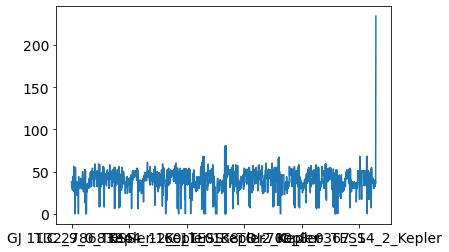

In [166]:
obsphases.iloc[650].plot()

In [153]:
observedphases = obsphases.sum(axis=1).values

(array([], dtype=int64),)

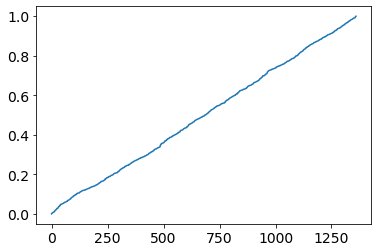

In [154]:
plt.plot(flarephases)
np.where(~np.isfinite(flarephases))

(array([], dtype=int64),)

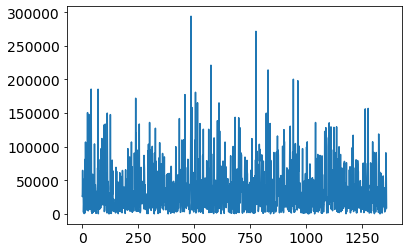

In [155]:
plt.plot(observedphases)
np.where(~np.isfinite(observedphases))

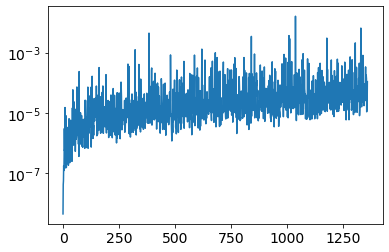

In [157]:
relphasefreq = flarephases/observedphases
plt.plot(relphasefreq)
plt.yscale("log");

In [158]:
np.min(relphasefreq), np.max(relphasefreq) 

(4.537395554365475e-09, inf)

In [72]:
# sample from the near-uniform expected distribution and get the AD statistic
A2 = sample_AD_for_custom_distribution(flarephases, observedphases, 1000)

# get p value and statistic value
pvalue, adtestvalue = get_pvalue_from_AD_statistic(flarephases, A2)

100%|██████████| 1000/1000 [00:26<00:00, 37.68it/s]


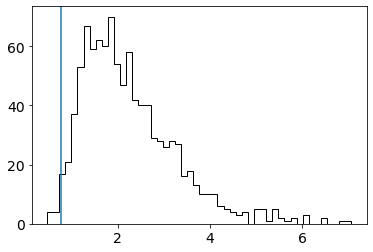

In [78]:
plt.hist(A2,bins=50,histtype="step",color="k")
plt.axvline(adtestvalue);

In [76]:
pvalue

0.026000000000000002

In [168]:
0.1 / 3.6 * 1359

37.75

In [169]:
0.1 *24*60

144.00000000000003

In [174]:
np.index(np.arange(7,17,1))

AttributeError: module 'numpy' has no attribute 'index'